In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *
from functions.helpers import organise_data, prcnt_hft_trading, all_sharpe, sharpe

# Enforcing the speed limit replication notebook

In [2]:
NRUNS = 5

In [18]:
# 1 setup parameters
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 0,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 1,
    "fundamental_value": 10,
    "std_fundamental": 0.0,
    "lft_sample_size": 0.03,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 1,
    "std_HFT_vol": 4,
    "max_order_expiration_ticks": 30,
    "transaction_fee": 0.0,
    "max_spread_exchange": 0.01,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 0.0, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 10,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 0.01,
    "hfm_adaptive_param": 0.2,
    "hfm_volatility_sensitivity": 1.9,
    # initial values
    "horizon_min": 1,
    "horizon_max": 9,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 5,
    "total_hft_money": 250,
    "hft_speed": 1,
}

# Experiment 1 Increase N-hft 

## Monte Carlo Simulations

In [19]:
#%%timeit
hfms = []
lfts = []
obs = []
for n_hft in range(1):
    parameters["n_hft"] = n_hft
    print('exp ', n_hft)
    hfms_seed = []
    lfts_seed = []
    obs_seed = []
    for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
        print('seed is ', seed)
        high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
        hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
        hfms_seed.append(hft)
        lfts_seed.append(lft)
        obs_seed.append(ob)
    
    hfms.append(hfms_seed)
    lfts.append(lfts_seed)
    obs.append(obs_seed)

exp  0
seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250


C:\Users\joerischasfoort\Documents\GitHub\hfm-abm\hft_model.py:21: RuntimeWarning: divide by zero encountered in true_divide
  adj_factor = np.divide(1., sum(all_speed))


tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750


# Spreads tighten

In [20]:
def av_bid_asks(orderbooks):
    mean_bid_asks = []
    for ob in orderbooks:
        bid_ask = [(ask - bid / np.mean(ask - bid)) / 2 for bid, ask in zip(ob.highest_bid_price_history, ob.lowest_ask_price_history)]
        # quoted bid_ask_spread = (Ask - Bid / Mid) / 2
        bid_ask = list(filter(lambda x: x >0, bid_ask))
        mean_bid_asks.append(np.mean(bid_ask))
    return mean_bid_asks

In [21]:
average_bid_asks = [av_bid_asks(orderbooks) for orderbooks in obs]

(0, 0.007096774193548404)

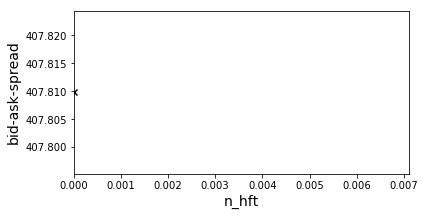

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(average_bid_asks)), [np.mean(bid_asks) for bid_asks in average_bid_asks], c='k', marker='x', label='Bid-ask')

#ax1.legend(frameon=True, loc='best', framealpha=0.8)

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)
#fig.savefig('auto_correlation.png')

# Volume increases

In [23]:
def vol(orderbooks):
    volume = []
    for ob in orderbooks:
        total_tick_volume = [sum(volumes) for volumes in ob.transaction_volumes_history]
        volume.append(sum(total_tick_volume))
    return volume

In [24]:
volumes = [vol(orderbooks) for orderbooks in obs]

(0, 0.007096774193548404)

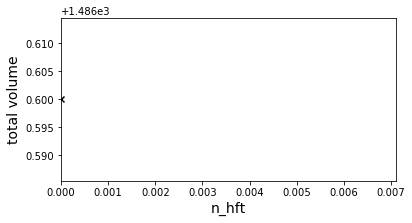

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(volumes)), [np.mean(volume) for volume in volumes], c='k', marker='x')

#ax1.legend(frameon=True, loc='best', framealpha=0.8)

ax1.set_ylabel('total volume', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Volatility decreases

In [11]:
def vola(orderbooks):
    volatility = []
    for ob in orderbooks:
        end_tick_price = ob.tick_close_price #[np.mean(prices) for prices in orderbook.transaction_prices_history]
        returns = pd.Series(np.array(end_tick_price)).pct_change()
        volatility.append(returns.std())
    return volatility

In [12]:
volatilities = [vola(orderbooks) for orderbooks in obs]

(0, 19.957096774193548)

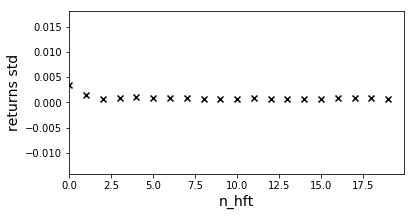

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(volatilities)), [np.mean(volatility) for volatility in volatilities], c='k', marker='x')

ax1.set_ylabel('returns std', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Orderbook depth decreases
Total orderbook depth decreases because HFMs generally take the other side of the orderbook and therefore empty the fuller side of the orderbook.

In [14]:
def depth(orderbooks):
    average_depth = []
    average_imbalance = []
    for ob in orderbooks:
        av_ask_depth = np.mean(ob.tick_bid_depth) #[np.mean(prices) for prices in orderbook.transaction_prices_history]
        av_bid_depth = np.mean(ob.tick_ask_depth)
        average_imbalance.append(np.mean(abs(np.array(ob.tick_bid_depth) - np.array(ob.tick_ask_depth))))
        average_depth.append(av_ask_depth + av_bid_depth)
    return average_depth, average_imbalance

In [15]:
depths = [depth(orderbooks)[0] for orderbooks in obs]
imbalance = [depth(orderbooks)[1] for orderbooks in obs]

(0, 19.957096774193548)

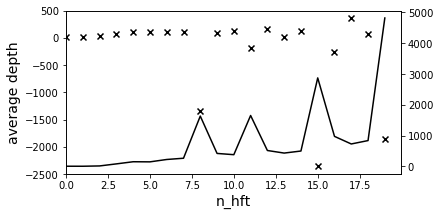

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(depths)), [np.mean(d) for d in depths], c='k', marker='x')

ax2 = ax1.twinx()
ax2.plot(range(len(imbalance)), [np.mean(i) for i in imbalance], c='k')

ax1.set_ylabel('average depth', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Complete picture

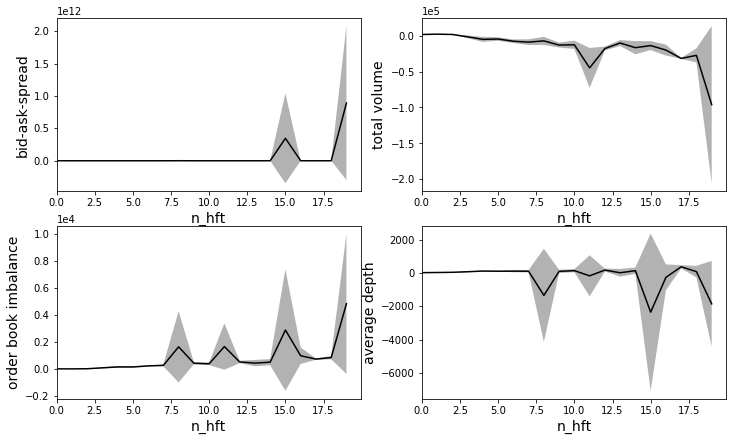

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

ax1.plot(range(len(average_bid_asks)), [np.mean(bid_asks) for bid_asks in average_bid_asks], c='k', label='Bid-ask')
ax1.fill_between(range(len(average_bid_asks)), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])+np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])-np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 alpha=0.3, facecolor='black')

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

ax2.plot(range(len(volumes)), [np.mean(volume) for volume in volumes], c='k')
ax2.fill_between(range(len(volumes)), 
                 np.array([np.mean(volume) for volume in volumes])+np.array([np.std(volume) for volume in volumes]), 
                 np.array([np.mean(volume) for volume in volumes])-np.array([np.std(volume) for volume in volumes]), 
                 alpha=0.3, facecolor='black')

ax2.set_ylabel('total volume', fontsize='14')
ax2.set_xlabel('n_hft', fontsize='14')
ax2.set_xlim(xmin=0)

ax3.plot(range(len(imbalance)), [np.mean(i) for i in imbalance], c='k')
ax3.fill_between(range(len(imbalance)), 
                 np.array([np.mean(i) for i in imbalance])+np.array([np.std(i) for i in imbalance]), 
                 np.array([np.mean(i) for i in imbalance])-np.array([np.std(i) for i in imbalance]), 
                 alpha=0.3, facecolor='black')
ax3.set_ylabel('order book imbalance', fontsize='14')
ax3.set_xlabel('n_hft', fontsize='14')
ax3.set_xlim(xmin=0)

ax4.plot(range(len(depths)), [np.mean(d) for d in depths], c='k')
ax4.fill_between(range(len(depths)), 
                 np.array([np.mean(d) for d in depths])+np.array([np.std(d) for d in depths]), 
                 np.array([np.mean(d) for d in depths])-np.array([np.std(d) for d in depths]), 
                 alpha=0.3, facecolor='black')

ax4.set_ylabel('average depth', fontsize='14')
ax4.set_xlabel('n_hft', fontsize='14')
ax4.set_xlim(xmin=0)

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('predictions.png')

# Experiment 2 Increase speed

In [16]:
#%%timeit
hfms = []
lfts = []
obs = []
for tick_p_min in range(1, 20):
    parameters["ticks_per_minute"] = tick_p_min
    print('exp ', tick_p_min)
    hfms_seed = []
    lfts_seed = []
    obs_seed = []
    for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
        print('seed is ', seed)
        high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
        hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
        hfms_seed.append(hft)
        lfts_seed.append(lft)
        obs_seed.append(ob)
    
    hfms.append(hfms_seed)
    lfts.append(lfts_seed)
    obs.append(obs_seed)

exp  1
seed is  0
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we here
we her

In [17]:
average_bid_asks = [av_bid_asks(orderbooks) for orderbooks in obs]
volumes = [vol(orderbooks) for orderbooks in obs]
volatilities = [vola(orderbooks) for orderbooks in obs]
depths = [depth(orderbooks)[0] for orderbooks in obs]
imbalance = [depth(orderbooks)[1] for orderbooks in obs]

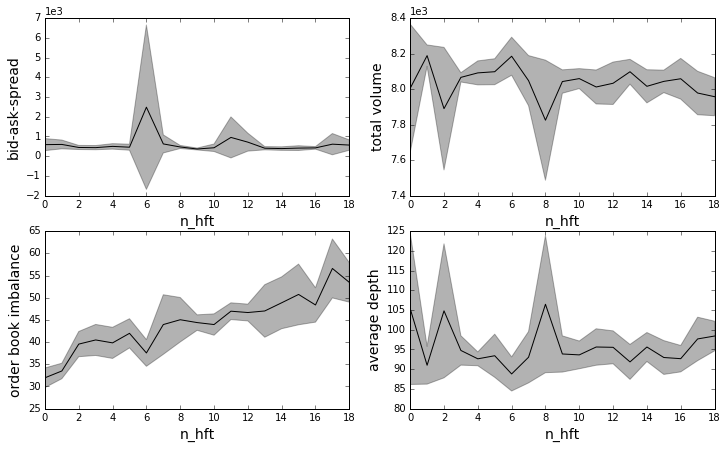

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

ax1.plot(range(len(average_bid_asks)), [np.mean(bid_asks) for bid_asks in average_bid_asks], c='k', label='Bid-ask')
ax1.fill_between(range(len(average_bid_asks)), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])+np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])-np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 alpha=0.3, facecolor='black')

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

ax2.plot(range(len(volumes)), [np.mean(volume) for volume in volumes], c='k')
ax2.fill_between(range(len(volumes)), 
                 np.array([np.mean(volume) for volume in volumes])+np.array([np.std(volume) for volume in volumes]), 
                 np.array([np.mean(volume) for volume in volumes])-np.array([np.std(volume) for volume in volumes]), 
                 alpha=0.3, facecolor='black')

ax2.set_ylabel('total volume', fontsize='14')
ax2.set_xlabel('n_hft', fontsize='14')
ax2.set_xlim(xmin=0)

ax3.plot(range(len(imbalance)), [np.mean(i) for i in imbalance], c='k')
ax3.fill_between(range(len(imbalance)), 
                 np.array([np.mean(i) for i in imbalance])+np.array([np.std(i) for i in imbalance]), 
                 np.array([np.mean(i) for i in imbalance])-np.array([np.std(i) for i in imbalance]), 
                 alpha=0.3, facecolor='black')
ax3.set_ylabel('order book imbalance', fontsize='14')
ax3.set_xlabel('n_hft', fontsize='14')
ax3.set_xlim(xmin=0)

ax4.plot(range(len(depths)), [np.mean(d) for d in depths], c='k')
ax4.fill_between(range(len(depths)), 
                 np.array([np.mean(d) for d in depths])+np.array([np.std(d) for d in depths]), 
                 np.array([np.mean(d) for d in depths])-np.array([np.std(d) for d in depths]), 
                 alpha=0.3, facecolor='black')

ax4.set_ylabel('average depth', fontsize='14')
ax4.set_xlabel('n_hft', fontsize='14')
ax4.set_xlim(xmin=0)

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('speed_predictions.png')

## Average HFT trades

In [19]:
def hft_in_match(match):
    for buy_sell in match:
        if 'HFT' in str(buy_sell):
            return True
    return False

In [20]:
def prcnt_hft_trading(ob):
    amount_matched_orders = 0
    hft_participating_orders = 0 
    for tick in ob.matched_bids_history:
        amount_matched_orders += len(tick)
        for match in tick:
            if hft_in_match(match):
                hft_participating_orders += 1
    
    percentage_hft_matches = hft_participating_orders / amount_matched_orders
    return percentage_hft_matches

In [36]:
def av_perc_hft_trading(obs):
    percentage_trades_hfm = [prcnt_hft_trading(ob) for ob in obs]
    return np.mean(percentage_trades_hfm), np.std(percentage_trades_hfm)

In [37]:
average_hft_trades = [av_perc_hft_trading(orderbooks)[0] for orderbooks in obs]
stds_hft_trades = [av_perc_hft_trading(orderbooks)[1] for orderbooks in obs]

(0, 18.0)

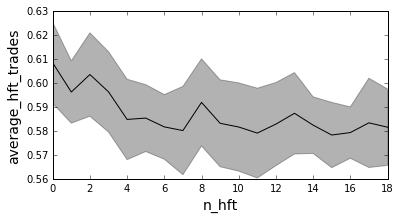

In [38]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(range(len(average_hft_trades)), average_hft_trades, c='k', label='average_hft_trades')
ax1.fill_between(range(len(average_hft_trades)), 
                 np.array(average_hft_trades)+np.array(stds_hft_trades), 
                 np.array(average_hft_trades)-np.array(stds_hft_trades), 
                 alpha=0.3, facecolor='black')

ax1.set_ylabel('average_hft_trades', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

## HFT profitability

In [24]:
def sharpe(periods, mean, standard_deviation):
    return np.sqrt(periods) * (mean / standard_deviation)

In [25]:
def all_sharpe(hfts):
    money = []
    stocks = []
    locked_in_profits = []
    for hft in hfts:
        money.append(np.array(hft.var_previous.money))
        stocks.append(np.array(hft.var_previous.stocks))
        locked_in_profits.append(np.array(hft.var_previous.locked_profit))
    all_profits = np.concatenate(locked_in_profits)
    all_sharpe = sharpe(len(all_profits), all_profits.mean(), all_profits.std())
    return all_sharpe

In [32]:
def av_sharpe_hft_trading(hfms):
    all_s = [all_sharpe(h) for h in hfms]
    return np.mean(all_s), np.std(all_s)

In [34]:
av_sharpes = [av_sharpe_hft_trading(h)[0] for h in hfms]
std_sharpes = [av_sharpe_hft_trading(h)[1] for h in hfms]

(0, 18.0)

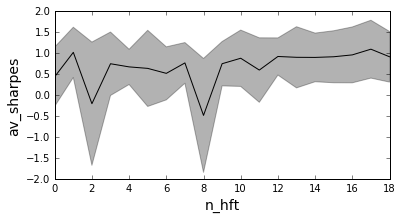

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

#av_sharpes

ax1.plot(range(len(av_sharpes)), av_sharpes, c='k', label='av_sharpes')
ax1.fill_between(range(len(av_sharpes)), 
                 np.array(av_sharpes)+np.array(std_sharpes), 
                 np.array(av_sharpes)-np.array(std_sharpes), 
                 alpha=0.3, facecolor='black')


ax1.set_ylabel('av_sharpes', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)